# Seasonality analysis

In [52]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_datareader import data as pdr
from statsmodels.tsa.seasonal import MSTL
import os.path
from datetime import datetime
from IPython.display import display, Markdown, Latex





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
symbol = 'ETH-USD'    # Ethereum USD



# set maximum number of years to analyze
max_num_of_years = 5



print('Analysis configuration:')
print()
print(f'Symbol selected: {symbol}')
print(f'Years to analysis: {datetime.now().year-1} until earliest {datetime.now().year-max_num_of_years}')


Analysis configuration:

Symbol selected: ETH-USD
Years to analysis: 2022 until earliest 2018


In [53]:
filename = f'{symbol}_{datetime.now().year}.csv'

if not os.path.isfile(filename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(filename)
else:
    df = pd.read_csv(filename, parse_dates=['Date'], index_col=['Date'])




print(f'Close prices of symbol {symbol} from {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")} loaded.')
print()
print()
print('Statistics:')
print(df.describe())

Close prices of symbol ETH-USD from 09.11.17 to 21.06.23 loaded.


Statistics:
             Close
count  2051.000000
mean   1179.109600
std    1149.801824
min      84.308296
25%     221.307137
50%     654.811951
75%    1812.612061
max    4812.087402


In [54]:
rolling_resolution = 200

df.index = pd.to_datetime(df.index)
df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values

resultDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(df.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = df[str(year) + '-01-01':str(year) + '-12-31']['Close'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    resultDf[str(year)] = curYearValues

resultMean = resultDf.mean(axis=1)
resultMin = resultDf.min(axis=1)
resultMax = resultDf.max(axis=1)
resultDf['mean'] = resultMean
resultDf['min'] = resultMin
resultDf['max'] = resultMax

lastYear = dt.date.today().year-1
range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='D')
resultDf['date'] = range
resultDf = resultDf.set_index('date')

# resultDf.index = resultDf.index.strftime('%d. %b')

resultDf

,2022,2021,2020,2019,2018,mean,min,max
date,,,,,,,,
2022-01-01,3769.697021,730.367554,130.802002,140.819412,772.640991,1108.865396,130.802002,3769.697021
2022-01-02,3829.564941,774.534973,127.410179,155.047684,884.443970,1154.200349,127.410179,3829.564941
2022-01-03,3761.380371,975.507690,134.171707,149.135010,962.719971,1196.582950,134.171707,3761.380371
2022-01-04,3794.056641,1040.233032,135.069366,154.581940,980.921997,1220.972595,135.069366,3794.056641
2022-01-05,3550.386963,1100.006104,136.276779,155.638596,997.719971,1188.005682,136.276779,3550.386963
...,...,...,...,...,...,...,...,...
2022-12-27,1212.791626,4037.547607,682.642334,127.214607,116.575912,1235.354417,116.575912,4037.547607
2022-12-28,1189.986084,3800.893066,730.397339,128.322708,137.647018,1197.449243,128.322708,3800.893066
2022-12-29,1201.595337,3628.531738,731.520142,134.757980,138.018341,1166.884708,134.757980,3628.531738


In [55]:
decompose = MSTL(df['Close'], periods=365)
decompose = decompose.fit()

numOfYears = 0
for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[str(year) + '-01-01':str(year) + '-12-31'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    resultDf['seasonal-' + str(year)] = curYearValues


resultDf

,2022,2021,2020,2019,2018,mean,min,max,seasonal-2022,seasonal-2021,seasonal-2020,seasonal-2019,seasonal-2018
date,,,,,,,,,,,,,
2022-01-01,3769.697021,730.367554,130.802002,140.819412,772.640991,1108.865396,130.802002,3769.697021,-33.264992,-21.231966,-46.163009,-49.718628,-47.206078
2022-01-02,3829.564941,774.534973,127.410179,155.047684,884.443970,1154.200349,127.410179,3829.564941,-1.807207,9.002731,-10.972769,-2.001385,15.162292
2022-01-03,3761.380371,975.507690,134.171707,149.135010,962.719971,1196.582950,134.171707,3761.380371,19.212758,36.606848,21.174221,33.514644,54.413469
2022-01-04,3794.056641,1040.233032,135.069366,154.581940,980.921997,1220.972595,135.069366,3794.056641,58.519955,66.683935,52.560153,62.543652,77.168031
2022-01-05,3550.386963,1100.006104,136.276779,155.638596,997.719971,1188.005682,136.276779,3550.386963,-5.004135,27.973347,74.473623,76.225428,82.419576
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1212.791626,4037.547607,682.642334,127.214607,116.575912,1235.354417,116.575912,4037.547607,81.334489,45.201816,20.612826,-18.731848,-66.195365
2022-12-28,1189.986084,3800.893066,730.397339,128.322708,137.647018,1197.449243,128.322708,3800.893066,-16.330517,-24.823037,-24.718388,-15.999885,-64.815463
2022-12-29,1201.595337,3628.531738,731.520142,134.757980,138.018341,1166.884708,134.757980,3628.531738,-73.142704,-71.485798,-63.045032,-35.251848,-55.709922


<Axes: title={'center': 'Trend'}, xlabel='Date'>

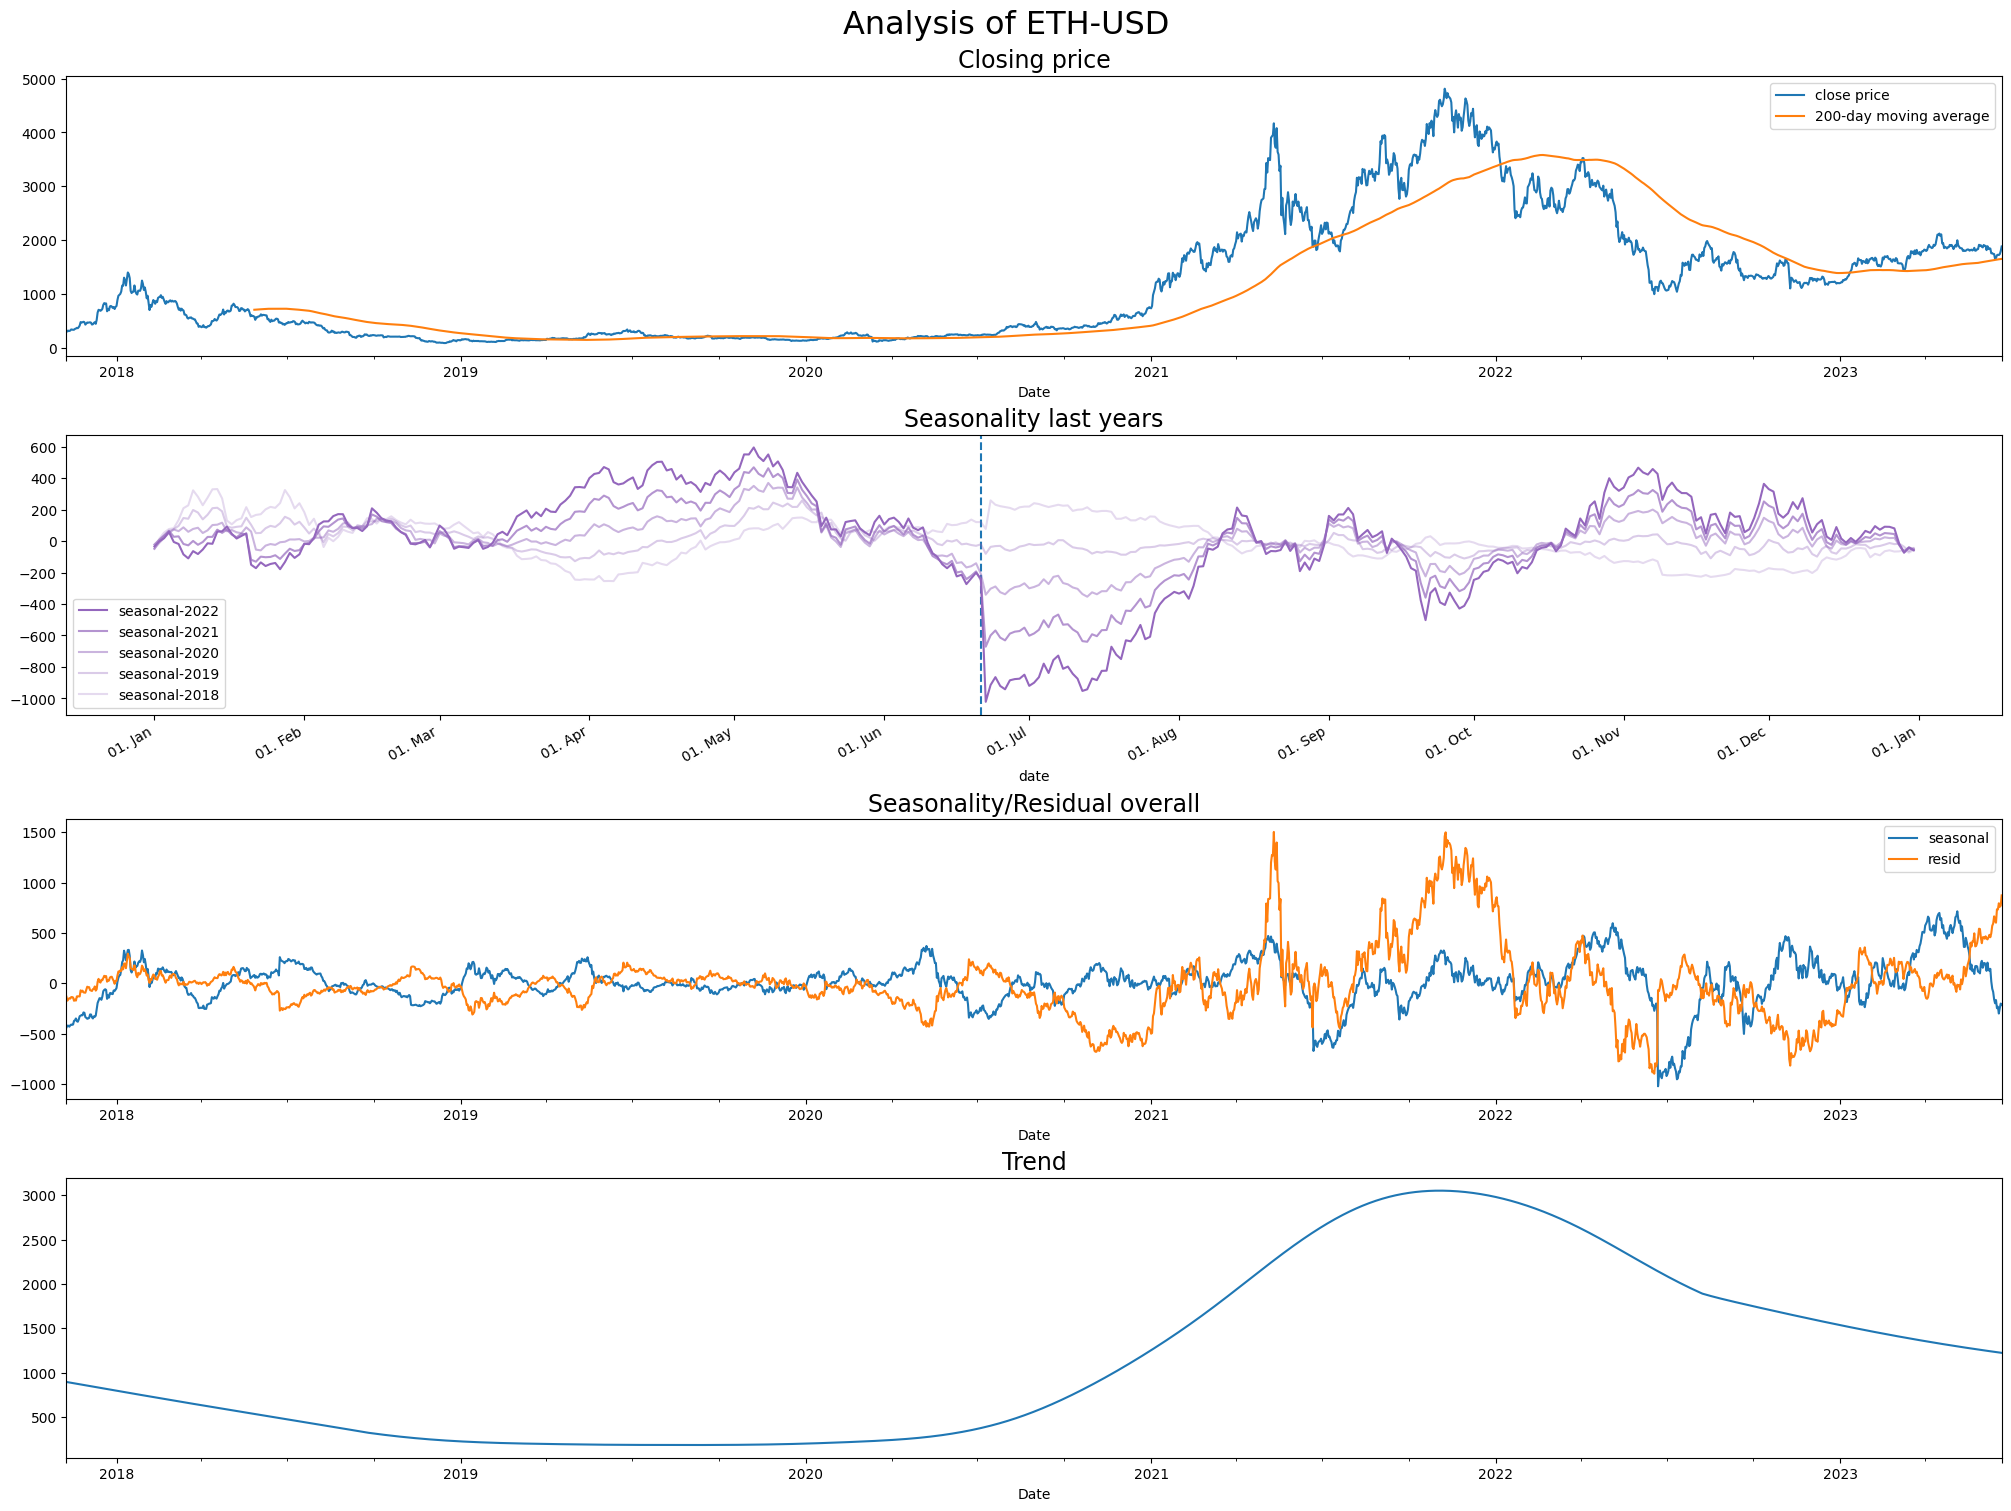

In [56]:
plt.figure(figsize=(20, 15), layout='constrained')
plt.suptitle('Analysis of ' + symbol, fontsize=23)

plt.subplot(411)
plt.title('Closing price', fontsize=17)
df['Close'].plot(legend=True, label='close price')
df['Close'].rolling(rolling_resolution).mean().plot(legend=True, label=str(rolling_resolution) + '-day moving average')

plt.subplot(412)
plt.title('Seasonality last years', fontsize=17)
plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d. %b"))
alpha_value = 1
for col in resultDf.columns:
    if col.startswith('seasonal-'):
        resultDf[col].plot(legend=True, color='tab:purple', alpha=alpha_value)
        alpha_value = alpha_value * 0.7

plt.subplot(413)
plt.title('Seasonality/Residual overall', fontsize=17)
decompose.seasonal.plot(legend=True)
decompose.resid.plot(legend=True)

plt.subplot(414)
plt.title('Trend', fontsize=17)
decompose.trend.plot()